## ARIMAX

This script fits an ARIMAX models to our data to nowcast GDP, using our non-GDP variables as exogenous regressors, and incorporating an autoregressive component (previous values of GDP), moving average component (previous residuals of GDP), and differencing (accounts for non-stationarity). 

I previously fit this model for nominal GDP, but got some odd results I couldn't reconcile. This model now forecasts GDP growth (percent change from four quarters ago), instead of raw GDP. A more stationary series like this will hopefully be easier to model.  

First, let's load the packages we need.

In [21]:
# PACKAGES
import pandas as pd
import numpy as np
import statsmodels.api as sm # for arimax
import pmdarima as pm # for arimax with AIC-based automatic order selection
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


Load data.

In [22]:
data = pd.read_csv("../data/data_wpk.csv")
data = data.drop("gdp", axis = 1)

We'll need a datetime index for this model.

In [23]:
data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")
data = data.asfreq("QE")

There's some missing values for our exogenous regressors, so let's filter those out.

In [24]:
data_filt = data.loc["2011-03-31" : "2025-06-30"]

Now let's split our data into independent and dependent variables

In [25]:
y = data_filt["gdp_yoy"]
X = data_filt.drop(columns=["gdp_yoy"])  # everything else = exogenous predictors

In [26]:
# model
arimax_ord_ones = sm.tsa.SARIMAX(
    y,
    exog=X,
    order=(1, 1, 1),   # all order 1 works well for many models
    enforce_stationarity=False,
    enforce_invertibility=False
)

# fit
fitted_arimax_ord_one = arimax_ord_ones.fit()
print(fitted_arimax_ord_one.summary())

                               SARIMAX Results                                
Dep. Variable:                gdp_yoy   No. Observations:                   58
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -100.367
Date:                Sat, 22 Nov 2025   AIC                            224.733
Time:                        18:19:49   BIC                            248.821
Sample:                    03-31-2011   HQIC                           234.048
                         - 06-30-2025                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
orders                -0.0033      0.019     -0.179      0.858      -0.040       0.033
employment         -6.908e-05      0.000     -0.526      0.599      -0.000       0.000
consumer_sentiment  

Now do nowcasting.

In [27]:
# extract last available values of exogenous regressors
X_next = data.drop(columns=["gdp_yoy"]).iloc[-2]  # shape (1, k)
print(X_next) # values we'll nowcast with

orders                3.170000e+01
employment            3.265000e+05
consumer_sentiment    5.833333e+01
unemploy_claims       2.749000e+06
bus_outlook           1.293333e+01
auto_sales            3.369800e+01
construction          2.230530e+05
itrade               -7.831100e+04
wtrade                7.113490e+05
Name: 2025-09-30 00:00:00, dtype: float64


In [28]:
nowcast = fitted_arimax_ord_one.get_forecast(steps=1, exog=X_next)
nowcast_value = nowcast.predicted_mean.iloc[0]
nowcast_ci = nowcast.conf_int().iloc[0]

print("Nowcasted GDP Growth:", nowcast_value)
print("95% CI:")
print(nowcast_ci)

Nowcasted GDP Growth: 0.47526949245836647
95% CI:
lower gdp_yoy   -2.519232
upper gdp_yoy    3.469771
Name: 2025-09-30 00:00:00, dtype: float64


Plot nowcast value. 

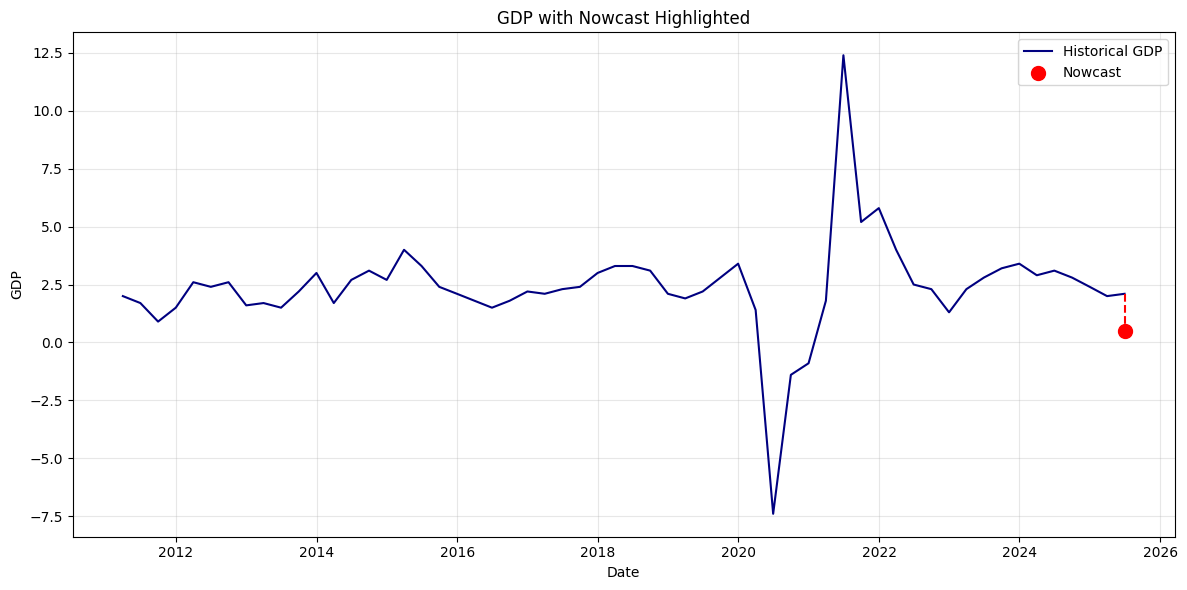

In [29]:
nowcast_date = pd.to_datetime("2025-06-30")
nowcast_series = pd.Series([nowcast_value], index=[nowcast_date])


plt.figure(figsize=(12, 6))

# plot historical GDP
plt.plot(data_filt.index, data_filt["gdp_yoy"], label="Historical GDP", color="navy")

# add the nowcast point
plt.scatter(nowcast_date, nowcast_value, 
            color="red", s=100, zorder=5, label="Nowcast")

# connect last point to nowcast
plt.plot([data_filt.index[-1], nowcast_date], 
         [data_filt["gdp_yoy"].iloc[-1], nowcast_value], 
         color="red", linestyle="--")

plt.title("GDP with Nowcast Highlighted")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




**Interpretation:**


TBD

Now let's try automatically choosing the order values based on the AIC.

In [30]:
auto = pm.auto_arima(
    y, 
    exogenous=X, 
    seasonal=False,
    stepwise=True
)

auto.summary()
order = auto.order

In [31]:
print(order)

(1, 0, 0)


A 0 order for the autoregressive component is kind of shocking? Perhaps it's very highly correlated with our regressors.

In [32]:
# model
arimax_auto_ord = sm.tsa.SARIMAX(
    y,
    exog=X,
    order=order,   # all order 1 works well for many models
    enforce_stationarity=False,
    enforce_invertibility=False
)

# fit
fitted_arimax_auto_ord = arimax_auto_ord.fit()
print(fitted_arimax_auto_ord.summary())

                               SARIMAX Results                                
Dep. Variable:                gdp_yoy   No. Observations:                   58
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -98.335
Date:                Sat, 22 Nov 2025   AIC                            218.671
Time:                        18:19:51   BIC                            241.144
Sample:                    03-31-2011   HQIC                           227.405
                         - 06-30-2025                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
orders                 0.0101      0.019      0.543      0.587      -0.026       0.046
employment         -1.631e-05   3.71e-05     -0.439      0.661   -8.91e-05    5.65e-05
consumer_sentiment  

Nowcasted GDP: -0.33520972880922423
95% CI:
lower gdp_yoy   -2.997451
upper gdp_yoy    2.327032
Name: 2025-09-30 00:00:00, dtype: float64


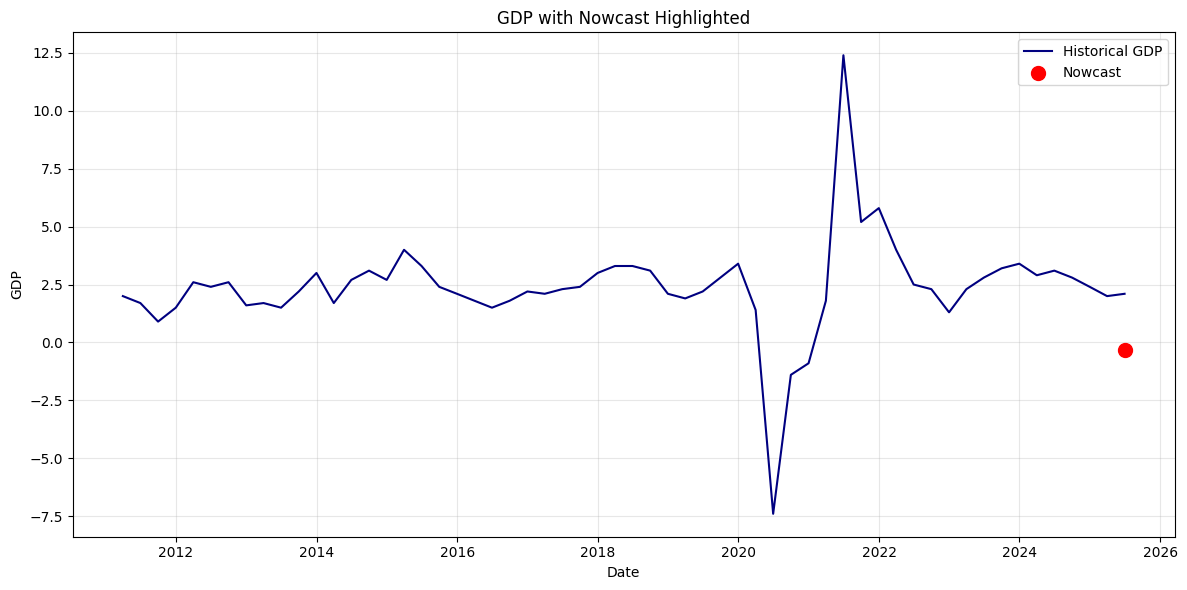

In [33]:
nowcast_auto = fitted_arimax_auto_ord.get_forecast(steps=1, exog=X_next)
nowcast_auto_value = nowcast_auto.predicted_mean.iloc[0]
nowcast_auto_ci = nowcast_auto.conf_int().iloc[0]

print("Nowcasted GDP:", nowcast_auto_value)
print("95% CI:")
print(nowcast_auto_ci)


nowcast_auto_series = pd.Series([nowcast_auto_value], index=[nowcast_date])


plt.figure(figsize=(12, 6))

# plot historical GDP
plt.plot(data_filt.index, data_filt["gdp_yoy"], label="Historical GDP", color="navy")

# add the auto chosen nowcast point
plt.scatter(nowcast_date, nowcast_auto_series, 
            color="red", s=100, zorder=5, label="Nowcast")


plt.title("GDP with Nowcast Highlighted")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

These predictions are much better than using raw GDP. Let's try just a simple ARIMA (for a simple comparison).

In [34]:
y = data_filt["gdp_yoy"]

# simple ARIMA model — start with all ones
arima_ones = sm.tsa.ARIMA(y, order=(1, 1, 1))
arima_ones_fitted = arima_ones.fit()

print(arima_ones_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                gdp_yoy   No. Observations:                   58
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -120.992
Date:                Sat, 22 Nov 2025   AIC                            247.984
Time:                        18:19:52   BIC                            254.113
Sample:                    03-31-2011   HQIC                           250.366
                         - 06-30-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4296      0.253      1.697      0.090      -0.067       0.926
ma.L1         -0.9995     10.843     -0.092      0.927     -22.252      20.253
sigma2         3.8665     41.919      0.092      0.9

Now to forecast. 

In [37]:
forecast_arima = arima_ones_fitted.get_forecast(steps=1)
nowcast_value_arima = forecast_arima.predicted_mean.iloc[0]
nowcast_ci_arima = forecast_arima.conf_int().iloc[0]


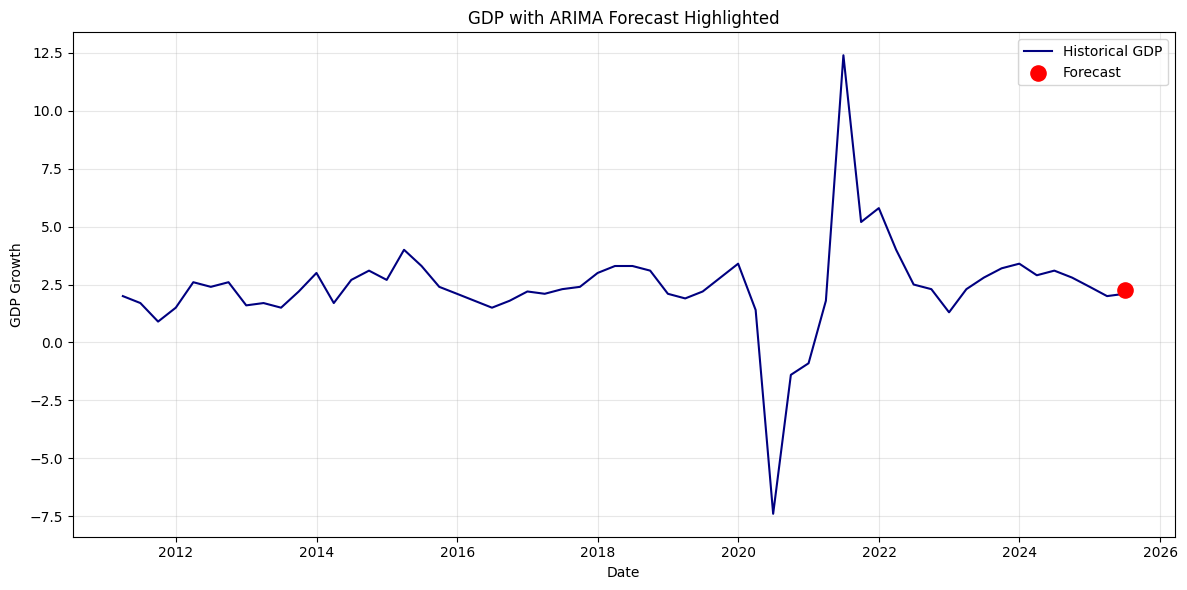

In [38]:
# make a Series for the forecasted value
nowcast_arima_series = pd.Series([nowcast_value_arima], index=[nowcast_date])

plt.figure(figsize=(12, 6))

# plot historical GDP
plt.plot(y.index, y, label="Historical GDP", color="navy")

# plot the forecast point
plt.scatter(nowcast_date, nowcast_value_arima,
            color="red", s=120, zorder=5, label="Forecast")

# dotted line connecting last real value to the forecast
plt.plot([y.index[-1], nowcast_date],
         [y.iloc[-1], nowcast_value_arima],
         color="red", linestyle="--")

plt.title("GDP with ARIMA Forecast Highlighted")
plt.xlabel("Date")
plt.ylabel("GDP Growth")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Basically just keeps the trend going -- as expected. 